In [1]:
import sys
import os
sys.path.append('..')
import src.svm_utils as svm_utils
import src.visualization_utils as viz_utils
import src.ds_utils as ds_utils
import numpy as np
import pandas as pd
import seaborn as sns
import src.clip_utils as clip_utils
import torch
sns.set()

In [2]:
BLUE = sns.color_palette("tab10")[0]
RED = sns.color_palette("tab10")[3]
ORANGE = sns.color_palette("tab10")[1]
BROWN = sns.color_palette("tab10")[5]
GRAY = sns.color_palette("tab10")[7]
GREEN = sns.color_palette("tab10")[2]

import matplotlib.pylab as pylab
params = {'legend.fontsize': 12,
          'figure.figsize': (5, 3),
         'axes.labelsize': 14,
         'axes.titlesize':16,
         'xtick.labelsize':14,
         'ytick.labelsize':14}
pylab.rcParams.update(params)


In [3]:
beton_root = "/mnt/cfs/projects/correlated_errors/betons"
experiment_root = "/mnt/cfs/projects/correlated_errors/experiments/celeba/celeba_age_norm/"

svm_name = "normalized_celeba_age_svm_same_val_as_train"
name = os.path.join(experiment_root, f"svm_checkpoints_same_val_as_train/{svm_name}.pt") # SVM output file
svm_model_name = os.path.join(experiment_root, f"svm_checkpoints_same_val_as_train/{svm_name}_model.pkl") # SVM output file

model_root = os.path.join(experiment_root, "models")
model_ckpt = os.path.join(model_root, "celeba_age_1_4/version_0/checkpoints/checkpoint_last.pt")
loss_upweight_root = os.path.join(experiment_root, "loss_vec_files")

In [4]:
processor = viz_utils.SVMProcessor(name, root=beton_root, checkpoint_path=model_ckpt, save_pred_probs=True)

-----------train_metrics--------------
{'Confusion Matrix': array([[    2,     0],
       [18850, 43178]]),
 'Model Accuracy': 0.9999677575366758,
 'SVM Accuracy': 0.6961147785186768,
 'SVM Balanced Accuracy': 0.8480525016784668}
-----------val_metrics--------------
{'Confusion Matrix': array([[1190,  158],
       [1287, 5465]]),
 'Model Accuracy': 0.8335802469135802,
 'SVM Accuracy': 0.8216049671173096,
 'SVM Balanced Accuracy': 0.8460895717144012}
-----------test_metrics--------------
{'Confusion Matrix': array([[ 3427,   634],
       [ 4347, 11554]]),
 'Model Accuracy': 0.7965634705941288,
 'SVM Accuracy': 0.7504758834838867,
 'SVM Balanced Accuracy': 0.7852509021759033}
Using default os_cache: False
Using default quasi_random: True
Using default val_aug: None
Using default loss_vec_file: None
Using default indices_file: None
Using default unlabeled_beton: None
Using default loss_upweight: 5
Using default bce: False
Using default cmnist: False

-----------CONFIG--------------
{   'a

100%|██████████| 621/621 [00:08<00:00, 73.74it/s] 


Accuracy 0.9999839067459106


100%|██████████| 81/81 [00:01<00:00, 41.60it/s]


Accuracy 0.833456814289093


100%|██████████| 200/200 [00:02<00:00, 82.37it/s] 

Accuracy 0.796563446521759


In [5]:
# Get cross val scores 
def check_efficacy(split='test', is_correct=None):
    age = processor.metrics[f'{split}_metrics']['classes'] # 0 if female, 1 if male
    gender = processor.metrics[f'{split}_metrics']['spuriouses'] #1 if blond, 2 if black hair, 0 if neither
    if is_correct is None:
        is_correct = processor.metrics[f'{split}_metrics']['ytrue']
    age_masks = {
        'old': age == 0,
        'young': age == 1,
    }
    gender_masks = {
        'female': gender == 0,
        'male': gender == 1
    }
    df = []
    for a, a_m in age_masks.items():
        for g, g_m in gender_masks.items():
            acc = is_correct[g_m & a_m].mean()
            print(f"{a}, {g}, {is_correct[g_m & a_m].mean():0.4f}, {len(is_correct[g_m & a_m])}")
            df.append([a, g, is_correct[g_m & a_m].mean()])
    df.append(['overall', '', is_correct.mean()])
    return (age_masks, gender_masks), df


In [6]:
print("val")
val_masks, _ = check_efficacy("val")
print("\ntest")
test_masks, _ = check_efficacy("test")
print("\ntrain")
train_masks, _ = check_efficacy("train")

val
old, female, 0.5235, 810
old, male, 0.8929, 3240
young, female, 0.9157, 3240
young, male, 0.5778, 810

test
old, female, 0.5569, 1916
old, male, 0.9038, 2932
young, female, 0.9148, 10331
young, male, 0.5714, 4783

train
old, female, 0.9998, 6203
old, male, 1.0000, 24812
young, female, 1.0000, 24812
young, male, 1.0000, 6203


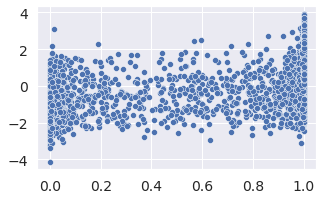

---- CONFIDENCE ------


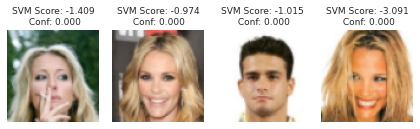

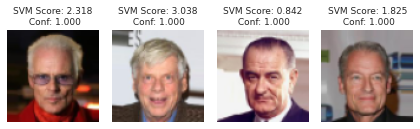

---- SVM ------


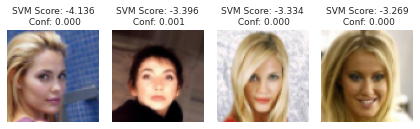

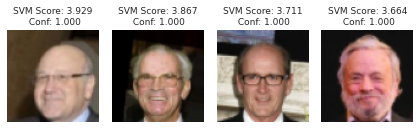

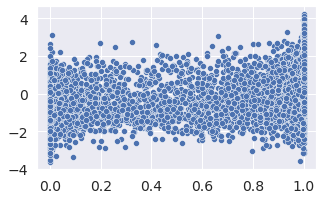

---- CONFIDENCE ------


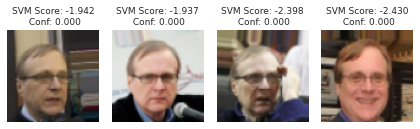

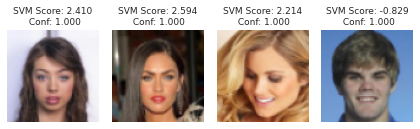

---- SVM ------


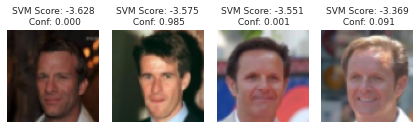

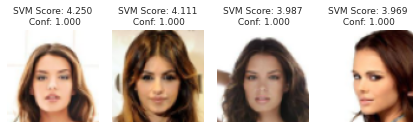

In [7]:
# display extremes for original model
os.makedirs("figures/celeba", exist_ok=True)
for c in range(2):
    processor.display_extremes(c, split='test', rows=1, columns=4, filename=f"figures/celeba/same_val_as_train_{c}_extremes")

## CLIP

In [8]:
clip_analyzer = clip_utils.ClipAnalyzer(
    processor=processor, svm_model_name=svm_model_name, class_names=['person', 'person'],
    clip_config_name='CELEBA', do_normalize=True, exclude_common=True)

100%|██████████| 200/200 [00:03<00:00, 51.01it/s]


consistent with old results 0.9997937293729373


  0%|          | 0/2 [00:00<?, ?it/s]

person



100%|██████████| 2/2 [00:00<00:00, 25.64it/s]

100%|██████████| 1/1 [00:00<00:00, 111.99it/s]

100%|██████████| 1/1 [00:00<00:00, 119.37it/s]

 50%|█████     | 1/2 [00:08<00:08,  8.18s/it]

reference



100%|██████████| 2/2 [00:10<00:00,  5.09s/it]


In [9]:
def get_cdf(arr, K_range=None):
    out = []
    if K_range is None:
        K_range = np.arange(10, len(arr), 10)
    for K in K_range:
        out.append(arr[:K].mean())
    out = np.array(out)
    return out, K_range

In [10]:
split = 'test'
test_dv = processor.metrics[f'{split}_metrics']['decision_values']
test_confs = processor.run_dict[split]['confs']
test_class = processor.metrics[f'{split}_metrics']['classes'] # 0 if female, 1 if male
test_pred_correct = processor.metrics[f'{split}_metrics']['ypred']
test_correct = processor.metrics[f'{split}_metrics']['ytrue']

0.6674187425030339
performing classify captions on svm
person a photo of a person
{'neg_captions': array(['a photo of a young woman who has high cheekbones',
       'a photo of a young woman who has earrings',
       'a photo of a young woman who has bushy eyebrows',
       'a photo of a woman who has straight hair',
       'a photo of a young woman who has straight hair',
       'a photo of a woman who has earrings',
       'a photo of a young man who has straight hair',
       'a photo of a woman who has high cheekbones',
       'a photo of a young woman who has heavy makeup on',
       'a photo of a young woman who has a mustache'], dtype='<U63'),
 'neg_latents': array([[-0.06793213,  0.58154297, -0.12976074, ..., -0.48291016,
        -0.11395264, -0.48486328],
       [-0.14086914,  0.00456238, -0.10284424, ..., -0.42285156,
        -0.020401  , -0.33911133],
       [ 0.1574707 ,  0.21765137, -0.17004395, ..., -0.4560547 ,
        -0.16125488,  0.04626465],
       ...,
       [ 0.10

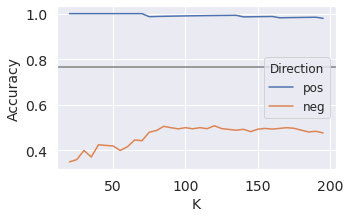

0.6742290439237033
performing classify captions on svm
person a photo of a person
{'neg_captions': array(['a photo of a man who has blond hair',
       'a photo of a man who has a smile',
       'a photo of a old person who has blond hair',
       'a photo of a old person who is wearing eyeglasses',
       'a photo of a old person who has heavy makeup on',
       'a photo of a old person who has narrow eyes',
       'a photo of a man who has narrow eyes',
       'a photo of a man who is wearing eyeglasses',
       'a photo of a old man who has blond hair',
       'a photo of a old person who has a smile'], dtype='<U63'),
 'neg_latents': array([[ 0.20336914,  0.18920898,  0.03167725, ..., -0.47021484,
        -0.16455078, -0.04666138],
       [-0.24133301,  0.33520508, -0.20739746, ..., -0.91796875,
        -0.16149902, -0.01461029],
       [ 0.22814941,  0.04803467, -0.08032227, ..., -0.33764648,
        -0.04150391, -0.03909302],
       ...,
       [-0.07501221,  0.39135742,  0.069519

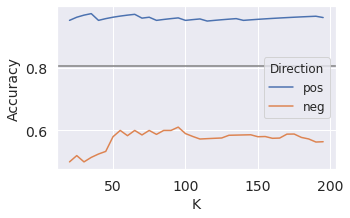

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt

saved_caption_and_most_relevant_imgs = {}
df_dict = {}
for METHOD in ['CLASSIFY']: # CLOSEST
    all_dfs = []
    for target_class in range(2):
        print(processor.metrics['cv_scores'][target_class])

        if METHOD == 'CLOSEST':
            print("performing closest")
            result = clip_analyzer.perform_closest_to_top_K(target_class, 'all')
        else:
            print("performing classify captions on svm")
            result = clip_analyzer.get_svm_style_top_K(target_class, 'all')
        print("--------")

        cdfs = {}
        class_mask = test_class==target_class
        masked_indices = np.arange(len(test_class))[class_mask]
        # K_range = np.arange(10, len(masked_indices), 10)
        K_range=np.arange(20, 200, 5)
        for caption_index in range(1):
            for direction in ['pos', 'neg']:
                caption_text = result[f'{direction}_captions'][caption_index]
                print(f"{direction}: {caption_text}")
                top_caption_latent = torch.tensor(result[f'{direction}_latents'][caption_index]).cuda()

                image_latents = clip_analyzer.clip_features['test'][class_mask].cuda()
                image_angles = clip_utils.order_descriptions_angle(mean_point=top_caption_latent.unsqueeze(0), query_points=image_latents)
                image_order = np.argsort(image_angles)[::-1]
                saved_caption_and_most_relevant_imgs[(METHOD, target_class, caption_index, direction)] = (masked_indices[image_order], caption_text)
                cdfs[direction], _ = get_cdf(test_correct[masked_indices[image_order]], K_range)
                # uncomment this to display the images
#                 processor._display_images(taken_index=masked_indices[image_order], taken_scores=image_angles[image_order],
#                             taken_confs=image_angles[image_order], split="test")

            df = pd.DataFrame()
            df['K'] = K_range
            for d, v in cdfs.items():
                df[d] = v
            df = df.melt('K', var_name='Direction', value_name='Accuracy')
            all_dfs.append(df)
            sns.lineplot(data=df, x='K', y='Accuracy', hue='Direction')
            plt.axhline(y=test_correct[masked_indices].mean(), xmin=0, xmax=K_range[-1], color='gray')
            plt.show()
    df_dict[METHOD] = all_dfs
    

In [12]:
split = 'test'


test_dv = processor.metrics[f'{split}_metrics']['decision_values']
test_confs = processor.run_dict[split]['confs']
test_class = processor.metrics[f'{split}_metrics']['classes']
test_pred_correct = processor.metrics[f'{split}_metrics']['ypred']
test_age_mask, test_gender_mask = test_masks
test_problematic = (test_age_mask['old'] & test_gender_mask['female']) | (test_age_mask['young'] & test_gender_mask['male'])

test_correct = processor.metrics[f'{split}_metrics']['ytrue']

percentage incorrect that is problematic 71.386%
percentage problematic that is incorrect 43.275%


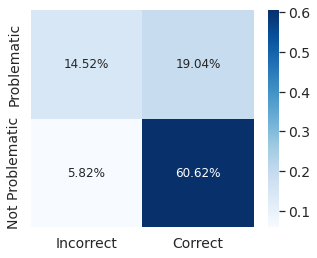

percentage flagged that is problematic 70.736%
percentage problematic that is flagged 82.087%


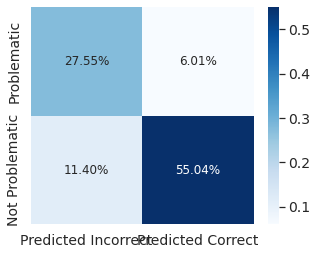

In [13]:
import sklearn.metrics as sklearn_metrics
import seaborn as sns
import matplotlib.pyplot as plt
conf_matrix = sklearn_metrics.confusion_matrix(y_true=(test_problematic == 0), y_pred=test_correct)
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.heatmap(conf_matrix/conf_matrix.sum(), fmt='.2%', annot=True, cmap='Blues')
ax.yaxis.set_ticklabels(['Problematic', 'Not Problematic'])
ax.xaxis.set_ticklabels(['Incorrect', 'Correct'])
perc_incorr_that_is_prob = (test_problematic & (test_correct == 0)).sum()/(test_correct == 0).sum()
perc_prob_that_is_incorr = (test_problematic & (test_correct == 0)).sum()/(test_problematic).sum()
print(f"percentage incorrect that is problematic {perc_incorr_that_is_prob:0.3%}")
print(f"percentage problematic that is incorrect {perc_prob_that_is_incorr:0.3%}")
plt.show()

conf_matrix = sklearn_metrics.confusion_matrix(y_true=(test_problematic == 0), y_pred=test_pred_correct)
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.heatmap(conf_matrix/conf_matrix.sum(), fmt='.2%', annot=True, cmap='Blues')
ax.yaxis.set_ticklabels(['Problematic', 'Not Problematic'])
ax.xaxis.set_ticklabels(['Predicted Incorrect', 'Predicted Correct'])
perc_incorr_that_is_prob = (test_problematic & (test_pred_correct == 0)).sum()/(test_pred_correct == 0).sum()
perc_prob_that_is_incorr = (test_problematic & (test_pred_correct == 0)).sum()/(test_problematic).sum()
print(f"percentage flagged that is problematic {perc_incorr_that_is_prob:0.3%}")
print(f"percentage problematic that is flagged {perc_prob_that_is_incorr:0.3%}")
plt.show()

In [16]:
import sklearn.metrics as sklearn_metrics
import seaborn as sns
import matplotlib.pyplot as plt
def print_confusion_matrices(class_mask=None, condition_name='Problematic', filename=None):
    if class_mask is None:
        class_mask = np.ones(len(test_problematic)).astype(bool)
        
    problematic = test_problematic[class_mask]
    correct = test_correct[class_mask]
    pred_correct = test_pred_correct[class_mask]
    dv_order = np.argsort(test_dv[class_mask])
    conf_order = np.argsort(test_confs[class_mask])
    
    print(f"Percentage that is {condition_name}: {problematic.mean():0.2%}")
    print(f"Percentage that is incorrect: {(correct==0).mean():0.2%}")
    print(f"Percentage that is flagged: {(pred_correct==0).mean():0.2%}")
    print("--")
    
    fig, ax_ = plt.subplots(1, 2, figsize=(12, 4))

    ax = ax_[0]
    conf_matrix = sklearn_metrics.confusion_matrix(y_true=(problematic == 0), y_pred=correct)
    sns.heatmap(conf_matrix/conf_matrix.sum(), fmt='.2%', annot=True, cmap='Blues', ax=ax)
    ax.yaxis.set_ticklabels([f'{condition_name}', f'Not {condition_name}'])
    ax.xaxis.set_ticklabels(['Incorrect', 'Correct'])
    perc_incorr_that_is_prob = (problematic & (correct == 0)).sum()/(correct == 0).sum()
    perc_prob_that_is_incorr = (problematic & (correct == 0)).sum()/(problematic).sum()
    print(f"percentage incorrect that is {condition_name} {perc_incorr_that_is_prob:0.3%}")
    print(f"percentage {condition_name} that is incorrect {perc_prob_that_is_incorr:0.3%}")

    print("-")
    conf_matrix = sklearn_metrics.confusion_matrix(y_true=(problematic == 0), y_pred=pred_correct)
    ax = ax_[1]
    sns.heatmap(conf_matrix/conf_matrix.sum(), fmt='.2%', annot=True, cmap='Blues', ax=ax)
    ax.yaxis.set_ticklabels([f'{condition_name}', f'Not {condition_name}'])
    ax.xaxis.set_ticklabels(['Predicted Incorrect', 'Predicted Correct'])
    perc_incorr_that_is_prob = (problematic & (pred_correct == 0)).sum()/(pred_correct == 0).sum()
    perc_prob_that_is_incorr = (problematic & (pred_correct == 0)).sum()/(problematic).sum()
    print(f"percentage flagged that is {condition_name} {perc_incorr_that_is_prob:0.3%}")
    print(f"percentage {condition_name} that is flagged {perc_prob_that_is_incorr:0.3%}")
    plt.show()
    
    K_range = np.arange(10, len(problematic), 10) 
    df = []
    def compute_fraction(arr):
        return arr.sum()/len(arr)
    
    for K in K_range:
        df.append([
            K,
            compute_fraction(problematic[dv_order[:K]]),
            compute_fraction(problematic[conf_order[:K]]),
            compute_fraction(problematic),
        ])
    df = pd.DataFrame(df, columns=['Top K Flagged', 'SVM Decision Value', 'Confidence', 'Base Population'])
    df = df.melt(['Top K Flagged'], var_name='Order', value_name=f'Fraction {condition_name}')
    fig, ax = plt.subplots(1, 1)
    sns.lineplot(data=df, x='Top K Flagged', y=f'Fraction {condition_name}', hue='Order', 
                 hue_order=['SVM Decision Value', 'Confidence', 'Base Population'], palette=[BLUE, RED, GRAY],
                 ax=ax)
#     handles, labels = ax.get_legend_handles_labels()
#     ax.legend(handles=handles, labels=labels)
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')
    
    plt.show()

old
Percentage that is Female: 39.52%
Percentage that is incorrect: 23.33%
Percentage that is flagged: 39.48%
--
percentage incorrect that is Female 75.066%
percentage Female that is incorrect 44.311%
-
percentage flagged that is Female 75.131%
percentage Female that is flagged 75.052%


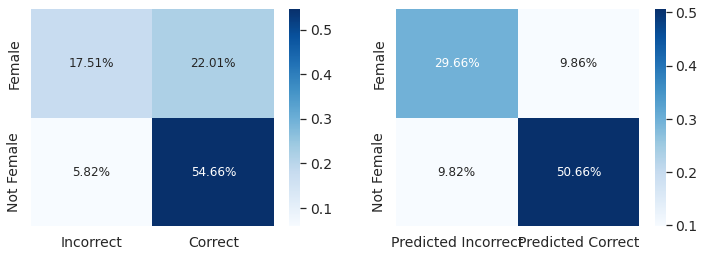

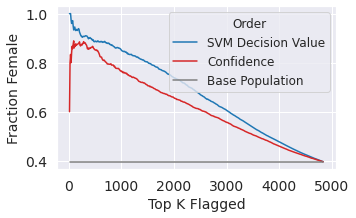

young
Percentage that is Male: 31.65%
Percentage that is incorrect: 19.39%
Percentage that is flagged: 38.77%
--
percentage incorrect that is Male 69.966%
percentage Male that is incorrect 42.860%
-
percentage flagged that is Male 69.300%
percentage Male that is flagged 84.905%


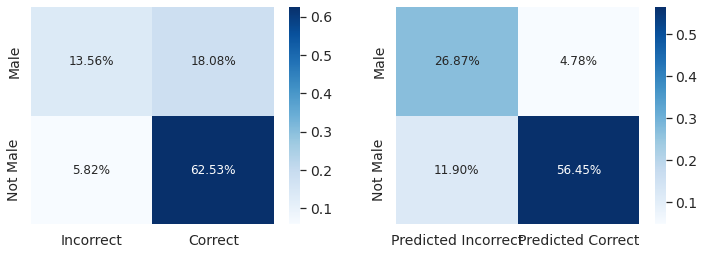

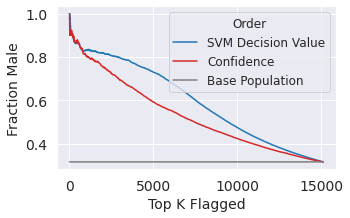

all
Percentage that is Problematic: 33.56%
Percentage that is incorrect: 20.34%
Percentage that is flagged: 38.94%
--
percentage incorrect that is Problematic 71.386%
percentage Problematic that is incorrect 43.275%
-
percentage flagged that is Problematic 70.736%
percentage Problematic that is flagged 82.087%


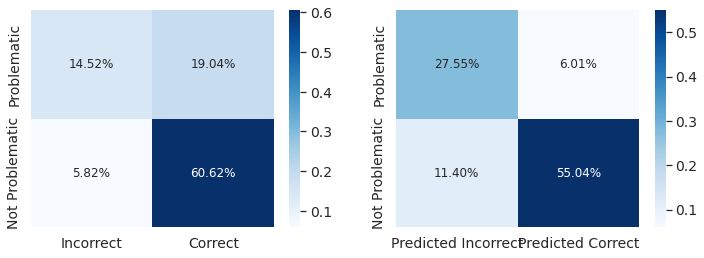

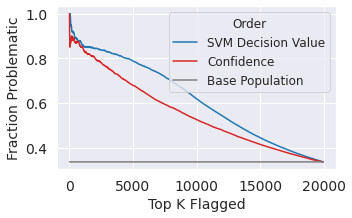

In [17]:

print("old")
df_0 = print_confusion_matrices(test_class==0, condition_name='Female', filename=f"figures/celeba/same_val_as_{0}_frac_plot.pdf")
print("young")
df_1 = print_confusion_matrices(test_class==1, condition_name='Male', filename=f"figures/celeba/same_val_as_{1}_frac_plot.pdf")
print("all")
_ = print_confusion_matrices(None)

In [102]:
(torch.load("/mnt/cfs/projects/correlated_errors/experiments/celeba/celeba_age_norm/loss_vec_files/oracle_balance.pt") == torch.load("/mnt/cfs/projects/correlated_errors/experiments/celeba/celeba_age_no_norm/loss_vec_files/oracle_balance.pt")).all()

tensor(True)

In [100]:
torch.load("/mnt/cfs/projects/correlated_errors/experiments/celeba/celeba_age_no_norm/loss_vec_files/oracle_balance.pt")

tensor([ 0.6250,  0.6250,  2.5000,  ..., -1.0000,  0.6250,  0.6250])

# Domino

In [6]:
import meerkat as mk

In [7]:
# need  pip install scikit-learn==0.24.2

In [86]:
pred_probs = processor.run_dict['val']['pred_probs']

In [87]:
latents = torch.tensor(processor.run_dict['val']['latents']).float()
probs = torch.nn.Softmax(dim=1)(latents)

NameError: name 'torch' is not defined

In [185]:
c = 0
val_dp = mk.DataPanel({
    "emb": clip_analyzer.clip_features['val'].numpy(),
    "target": processor.run_dict['val']['ys'] == c,
    "pred_probs":pred_probs[:, c],  
})

In [186]:
from domino import DominoSlicer
domino = DominoSlicer(
    y_log_likelihood_weight=10,
    y_hat_log_likelihood_weight=10,
#     n_mixture_components=25,
    n_slices=2
)

In [187]:
domino.fit(data=val_dp, embeddings='emb', targets='target', pred_probs='pred_probs')

  0%|          | 0/100 [00:00<?, ?it/s]

In [188]:
test_dp = mk.DataPanel({
    "emb": clip_analyzer.clip_features['test'].numpy(),
    "target": processor.run_dict['test']['ys'] == c,
    "pred_probs":processor.run_dict['test']['pred_probs'][:, c],  
})
out = domino.predict_proba(data=test_dp, embeddings='emb', targets='target', pred_probs='pred_probs')
test_dp['domino_slices'] = out

In [179]:
from domino import generate_candidate_descriptions
phrase_templates = [
    "a photo of [MASK].",
    "a photo of {} [MASK].",
    "a photo of [MASK] {}.",
    "a photo of [MASK] {} [MASK].",
]

text_dp = generate_candidate_descriptions(
    templates=phrase_templates,
    num_candidates=10_000
)

[nltk_data] Downloading package words to
[nltk_data]     /mnt/nfs/home/saachij/nltk_data...
[nltk_data]   Package words is already up-to-date!
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/625 [00:00<?, ?it/s]

In [180]:
from domino import embed
text_dp = embed(
    text_dp, 
    input_col="output_phrase", 
    encoder="clip",
    device='cuda'
)

  0%|          | 0/79 [00:00<?, ?it/s]

In [211]:
from domino import describe
test_dp["target"] = test_dp["target"].astype(int)

descriptions = describe(
    data=test_dp,
    embeddings="emb",
    targets="target",
    slices="domino_slices",
    text=text_dp,
    text_embeddings="clip(output_phrase)",
    slice_idx=1
)
descriptions.lz[(-descriptions["score"]).argsort()][:10]

,score (NumpyArrayColumn),phrase (PandasSeriesColumn)
0,3.293185,a photo of sandra bullock.
1,2.933086,a photo of a supernatural woman.
2,2.887938,a photo of her eighteenth birthday.
3,2.857492,a photo of her drastically changed.
4,2.817893,a photo of her breathtaking.
5,2.796047,a photo of kate moss.
6,2.772779,a photo of a stunning woman.
7,2.761548,a photo of the actress.
8,2.736819,a photo of her directorial debut.
9,2.725654,a photo of her posted online.


In [167]:
test_problematic[np.argsort(out[:, 1])]

array([False, False,  True, ...,  True,  True,  True])

In [191]:
groups = [out[:, i] > 0.0001 for i in range(out.shape[-1])]
for g in groups:
    print("----")
    for a in [0,1]:
        for b in [0, 1]:
            print("age", a, "gender", b, g[(age == a) & (gender==b)].mean())

----
age 0 gender 0 0.0
age 0 gender 1 0.0
age 1 gender 0 0.0664988868454167
age 1 gender 1 0.33807233953585614
----
age 0 gender 0 0.3522964509394572
age 0 gender 1 0.059686221009549796
age 1 gender 0 0.0
age 1 gender 1 0.0


In [202]:
split = 'test'


test_dv = processor.metrics[f'{split}_metrics']['decision_values']
test_confs = processor.run_dict[split]['confs']
test_class = processor.metrics[f'{split}_metrics']['classes']
test_pred_correct = processor.metrics[f'{split}_metrics']['ypred']
test_age_mask, test_gender_mask = test_masks
test_problematic = (test_age_mask['old'] & test_gender_mask['female']) | (test_age_mask['young'] & test_gender_mask['male'])

test_correct = processor.metrics[f'{split}_metrics']['ytrue']

In [212]:
def compute_fraction(arr):
    return arr.sum()/len(arr)
    
domino_order = np.argsort(out.max(1))[::-1]
dv_order = np.argsort(test_dv)
conf_order = np.argsort(test_confs)
df = []
for K in np.arange(5, len(test_problematic), 5):
    df.append([
        K,
        compute_fraction(test_problematic[domino_order[:K]]),
        compute_fraction(test_problematic[dv_order[:K]]),
        compute_fraction(test_problematic[conf_order[:K]]),
    ])
df = pd.DataFrame(df, columns=['K', 'Domino', 'SVM', 'CONF'])
df = df.melt('K', var_name='Method', value_name='Fraction Problematic')

In [208]:
df

,K,Method,Fraction Problematic
0,5,Domino,0.600000
1,10,Domino,0.700000
2,15,Domino,0.666667
3,20,Domino,0.600000
4,25,Domino,0.560000
...,...,...,...
11971,19940,CONF,0.335807
11972,19945,CONF,0.335824
11973,19950,CONF,0.335739
11974,19955,CONF,0.335655


<AxesSubplot:xlabel='K', ylabel='Fraction Problematic'>

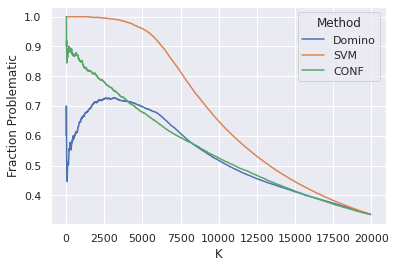

In [213]:
sns.lineplot(data=df, x='K', y='Fraction Problematic', hue='Method')